In [97]:
import math
import warnings
import numpy as np
import qiskit.quantum_info as qi

from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import MCMT, ZGate
from qiskit.visualization import plot_distribution
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService

In [98]:
def Oracle(marked_states):
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    
    # length of bits
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    for target in marked_states:
        # bitfilp
        rev_target = target[::-1]
        # get an index with a value of 0 as an array
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]          
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
        # The phase changes only what want to find it
    return qc

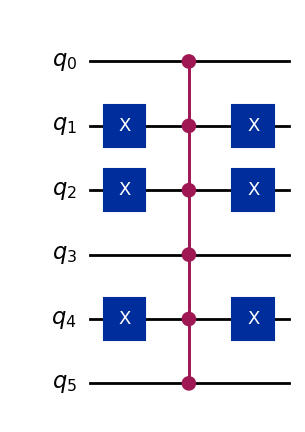

In [103]:
marked_states = ["101001"]
#marked_states = ["101011", "010111"]

circ_oracle = Oracle(marked_states)
circ_oracle.draw(output="mpl")

In [100]:
num_bits = len(marked_states[0])

# matrix R
def RMatrix(num_bits):
    mat_R = np.zeros((2**num_bits, 2**num_bits))
    for i in range(2**num_bits):
        for j in range(2**num_bits):
            if i != j:
                mat_R[i][j] = 0
            else:
                if i == 0:
                    mat_R[i][j] = 1
                else:
                    mat_R[i][j] = -1
    return mat_R
    
R = RMatrix(num_bits)

# represent as binary to bitwise dot product
get_bin = lambda x, n: format(x, 'b').zfill(n)
# matrix W
def WMatrix(num_bits):
    mat_W = np.zeros((2**num_bits, 2**num_bits))
    for i in range(2**num_bits):
        for j in range(2**num_bits):
            i_b = get_bin(i, num_bits)
            j_b = get_bin(j, num_bits)
            bitsum = 0
            for k in range(num_bits):
                if int(i_b[k])*int(j_b[k]) == 1:
                    bitsum += 1
            if bitsum % 2 == 0:
                mat_W[i][j] = 1
            else:
                mat_W[i][j] = -1
    return mat_W

W = WMatrix(num_bits)

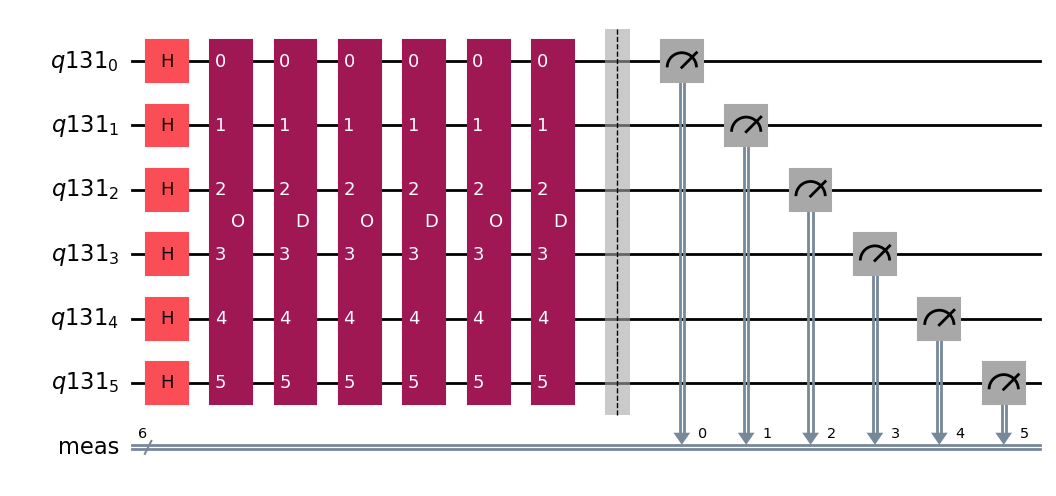

In [101]:
# D matrix is WRW
D = np.dot(np.dot(W,R), W) / 2**num_bits
D_op = qi.Operator(D)

oracle_op = qi.Operator(circ_oracle)

q = QuantumRegister(num_bits)
qc = QuantumCircuit(q)
qc.h(range(num_bits))
# iterate sqrt(N/K) times
num_iteration = math.ceil(math.sqrt(num_bits) / len(marked_states))
for i in range(math.ceil(num_iteration)):
    qc.unitary(oracle_op, q, label="O")
    qc.unitary(D_op, q, label="D")
qc.measure_all()
qc.draw("mpl")

In [102]:
aersim = AerSimulator()
result_ideal = aersim.run(qc).result()
counts_ideal = result_ideal.get_counts(0)
print('Counts(ideal):', counts_ideal)

provider = QiskitRuntimeService()
backend = provider.get_backend("ibm_kyoto")
aersim_backend = AerSimulator.from_backend(backend)
result_noise = aersim_backend.run(qc).result()
counts_noise = result_noise.get_counts(0)
print(counts_noise)

Counts(ideal): {'010100': 3, '001111': 5, '101100': 6, '101010': 5, '111111': 6, '001101': 8, '101110': 6, '010110': 8, '101111': 2, '101001': 630, '000011': 10, '101011': 4, '100101': 4, '001110': 9, '100100': 8, '011111': 7, '011011': 4, '001100': 7, '111101': 5, '001000': 5, '111010': 3, '010011': 9, '100001': 7, '010101': 4, '010111': 5, '111110': 10, '000110': 4, '010001': 5, '111100': 8, '010000': 3, '100000': 15, '100110': 5, '000111': 13, '110000': 9, '000101': 5, '110011': 4, '001010': 3, '111001': 6, '001011': 2, '111011': 6, '011000': 8, '000000': 6, '011110': 3, '110100': 6, '110101': 4, '000010': 8, '100011': 9, '110110': 5, '011001': 9, '101000': 7, '011100': 14, '110010': 8, '011101': 5, '011010': 9, '000001': 4, '010010': 5, '110001': 5, '100111': 5, '000100': 11, '100010': 5, '111000': 2, '101101': 9, '001001': 6, '110111': 3}


qiskit_runtime_service.__init__:INFO:2024-03-27 16:38:31,871: Default instance: ibm-q/open/main


{'101101': 1, '010011': 3, '001000': 5, '010111': 5, '101100': 8, '110100': 6, '111110': 9, '100100': 2, '010000': 8, '001100': 5, '111101': 5, '111010': 5, '101110': 8, '001010': 12, '111001': 19, '011111': 8, '011011': 6, '100110': 7, '100000': 20, '000011': 7, '110000': 6, '110001': 16, '101011': 47, '001111': 7, '101010': 9, '000111': 4, '001110': 7, '010100': 8, '010001': 5, '000110': 5, '011101': 11, '011010': 8, '000001': 4, '101001': 387, '101111': 5, '110111': 10, '100001': 48, '010101': 12, '110110': 5, '100011': 14, '000010': 8, '110101': 5, '001011': 10, '111011': 9, '011000': 7, '001001': 12, '111000': 13, '100010': 8, '011110': 7, '000000': 9, '101000': 81, '011001': 5, '111100': 11, '001101': 9, '100111': 4, '000100': 8, '010110': 3, '010010': 7, '011100': 10, '110010': 6, '100101': 10, '111111': 5, '110011': 3, '000101': 7}
